# Day and Night Image Classifier

* Dataset : day / night rgb image. 100 day images, 100 night images
* Goal : 두 종류의 이미지에서 구별된 특징을 찾아 분류
* http://mvrl.cs.uky.edu/datasets/
* 입력 > 탐색 > 전처리 > 특성 추출 > 분류

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob

In [2]:
### Input
image_dir_train = './image_classifier/training'
image_dir_test = './image_classifier/test/'

In [3]:
train_images = glob.glob(image_dir_train+'/*/*')
test_images = glob.glob(image_dir_test+'/*/*')
print(len(train_images), len(test_images))

240 160


In [4]:
train_day_images = glob.glob('./image_classifier/training/day/*.jpg')
train_night_images = glob.glob('./image_classifier/training/night/*.jpg')
print(len(train_day_images), len(train_night_images))

120 120


In [5]:
test_day_images = glob.glob('./image_classifier/test/day/*.jpg')
test_night_images = glob.glob('./image_classifier/test/night/*.jpg')
print(len(test_day_images), len(test_night_images))

80 80


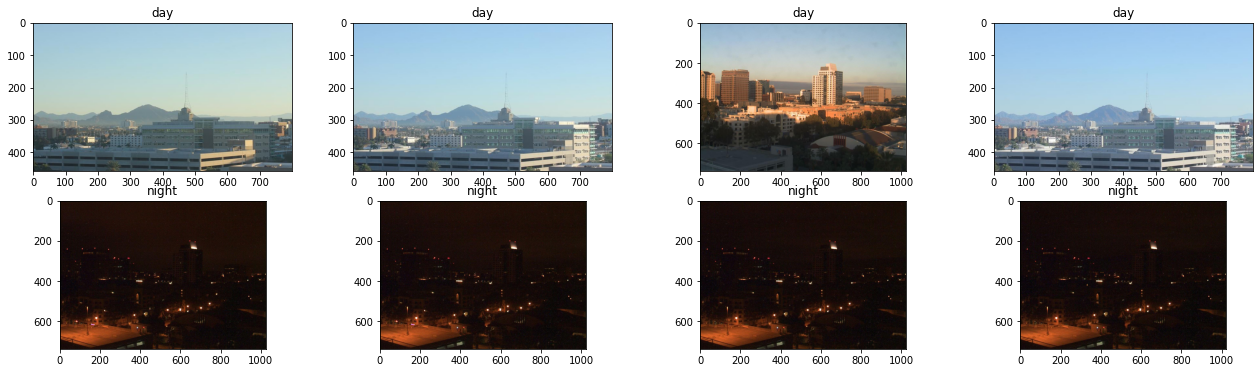

In [6]:
ncols=4
figure, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(22, 6))

for i, v in enumerate(train_day_images[:ncols]):
    ax[0][i].imshow(mpimg.imread(v))
    ax[0][i].set_title('day')

for i, v in enumerate(train_night_images[:ncols]):
    ax[1][i].imshow(mpimg.imread(v))
    ax[1][i].set_title('night')    

# plt.show()

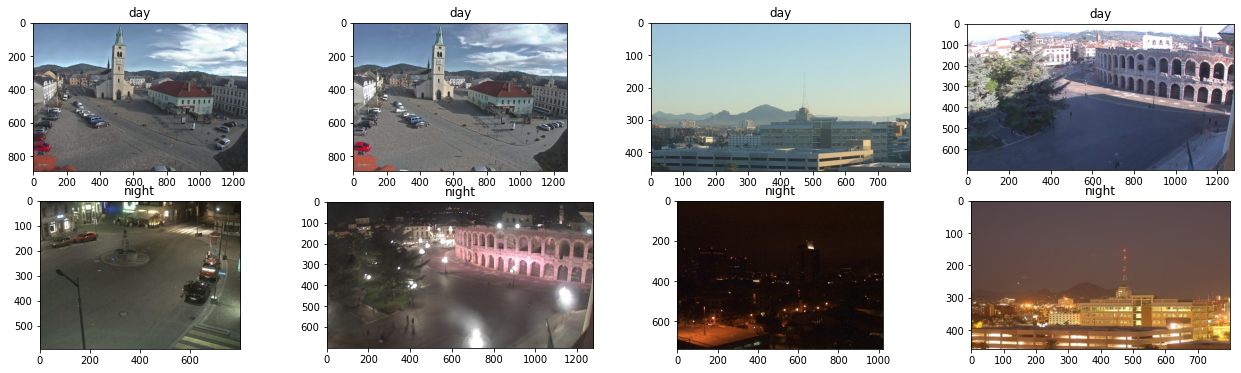

In [7]:
ncols=4
figure, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(22, 6))

for i, v in enumerate(train_day_images[:ncols]):
    rand_i = np.random.randint(0, len(train_day_images))
    image = mpimg.imread(train_day_images[rand_i])
    ax[0][i].imshow(image)
    ax[0][i].set_title('day')

for i, v in enumerate(train_night_images[:ncols]):
    rand_i = np.random.randint(0, len(train_night_images))
    image = mpimg.imread(train_night_images[rand_i])
    ax[1][i].imshow(image)
    ax[1][i].set_title('night') 

### 전처리(Preprocessing)

In [8]:
# 데이터 적재
import os
def load_dataset(image_dir):
    image_list = []
    image_types = ["day", "night"]

    for image_type in image_types:
        file_path = glob.glob(os.path.join(image_dir, image_type, '*.jpg'))
        for file in file_path:
            image = mpimg.imread(file)
            image_list.append((image, image_type))
    return image_list

In [9]:
train_image_list = load_dataset(image_dir_train)
test_image_list = load_dataset(image_dir_test)

In [10]:
len(train_image_list)

240

In [11]:
train_image_list[119][1], train_image_list[120][1]

('day', 'night')

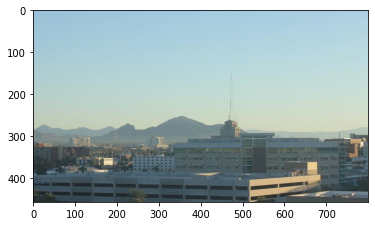

In [12]:
plt.imshow(train_image_list[0][0])

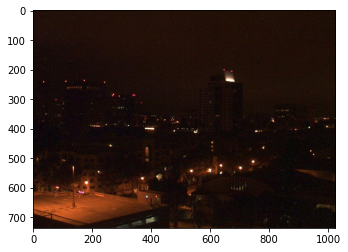

In [13]:
plt.imshow(train_image_list[120][0])

In [14]:
# 표준화(Resize, Label Encoding)
def resize_input(image):
    resized_image = cv2.resize(image, (1200, 600))
    return resized_image

def label_encode(label):
    if label == 'day':
        val = 1
    else:
        val = 0
    return val

In [15]:
def standard_image(image_list):
    standard_list = []
    
    for image, label in image_list:
        standard_image = resize_input(image)
        standard_label = label_encode(label)
        
        standard_list.append([standard_image, standard_label])
        
    return standard_list

In [16]:
std_train_list = standard_image(train_image_list)
std_test_list = standard_image(test_image_list)

len(std_train_list), len(std_test_list)

(240, 160)

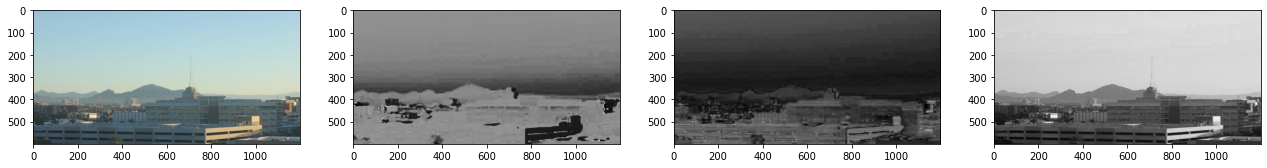

In [17]:
# 특성 추출
index = 0
test_image = std_train_list[index][0]
hsv = cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv)

figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(22, 6))
images = [test_image, h, s, v]
for i in range(4):
    if i > 0:
        ax[i].imshow(images[i], cmap='gray')
    else:
        ax[i].imshow(images[i])

In [18]:
def average_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    return np.sum(v) / (v.shape[0] * v.shape[1])

### 분류

- 평균 밝기값을 기준으로 day 또는 night 인지 예측

In [19]:
def predict_label(image):
    avg = average_brightness(image)
    threshold = 99
    if avg > threshold:
        predicted_label = 1 # day
    else:
        predicted_label = 0 # night
    return predicted_label

In [20]:
# 테스트
missclassified_list = []
for i, v in enumerate(std_test_list):
    image, label = v[0], v[1]
    predict = predict_label(image)
    if label != predict:
        missclassified_list.append([image, predict, label, i])
len(missclassified_list)

10

In [21]:
for m in missclassified_list:
    print(average_brightness(m[0]), *m[1:])

98.88646944444444 0 1 29
93.18199444444444 0 1 65
108.24727222222222 1 0 133
110.79537916666666 1 0 134
111.84506111111111 1 0 135
111.31686527777778 1 0 136
116.52359305555555 1 0 138
176.83882916666667 1 0 139
175.58647638888888 1 0 140
106.49033333333334 1 0 159


In [22]:
accuracy = (len(std_test_list) - len(missclassified_list)) / len(std_test_list)
accuracy

0.9375

[0] average brightness: 93.18199444444444
[1] average brightness: 176.83882916666667
[2] average brightness: 116.52359305555555
[3] average brightness: 111.31686527777778


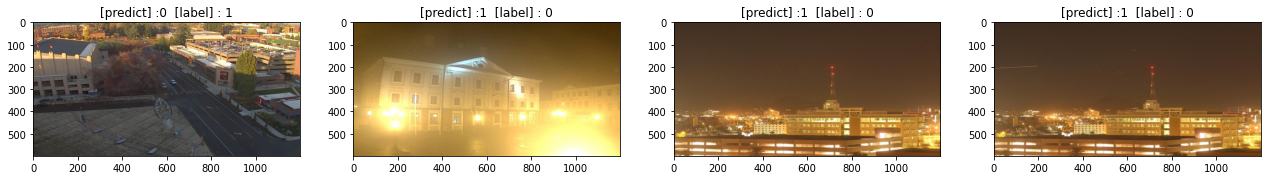

In [23]:
figure, axes = plt.subplots(nrows=1 , ncols=4, figsize=(22, 6))
for i in range(4):
    rand_i = np.random.randint(0, len(missclassified_list))
    image = missclassified_list[rand_i][0]
    predict = missclassified_list[rand_i][1]
    label = missclassified_list[rand_i][2]
    
    axes[i].imshow(image)
    axes[i].set_title("[predict] :" + str(predict) + "  [label] : " + str(label))
    print([i], "average brightness:", average_brightness(image))